In [ ]:
!pip install umap
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=727bf380c125e34bcad09b6ee7e02cf0b389430c796a479d711a819af6db5927
  Stored in directory: /root/.cache/pip/wheels/d4/13/91/2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# please install bokeh and umap before running this notebook :)
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE

from sklearn import datasets
from matplotlib import offsetbox

import umap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
import random

random.seed(2021)

from IPython.display import set_matplotlib_formats
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/EPAM_Data_Science/Homeworks/HW2/data/bank-additional-full.csv"
data = pd.read_csv(path, sep=";")
print(data.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

Part1: EDA

In [ ]:
print(data.shape)

(41188, 21)


In [ ]:
print(data.dtypes.value_counts())
print(data.dtypes)

object     11
int64       5
float64     5
dtype: int64
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


In [ ]:
continious_features = data.select_dtypes('number').columns
categorical_features = list(data.select_dtypes(object).columns)
continious_cols = list(continious_features)
nominal_cols = categorical_features.copy()
nominal_cols.remove("education")
nominal_cols.remove("y")
ordinal_cols = ["education"]
y = ["y"]
# nominal_cols
# continious_cols

In [ ]:
print(data.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


Very cool we have no missing values. However the point 8 in the text description of the data told us that there are missing values tagged as "unknown" in the categorical attributes.

In [ ]:
data[categorical_features] = data[categorical_features].replace("unknown", np.NaN)
print(data[categorical_features].isnull().sum())

job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


We can see that we actually have some missing values. The default column has the largest amount of missing values about 20%.

In [ ]:
 descriptive_stats = data.describe(include='all')
 print(descriptive_stats)

                age     job  marital          education default housing  \
count   41188.00000   40858    41108              39457   32591   40198   
unique          NaN      11        3                  7       2       2   
top             NaN  admin.  married  university.degree      no     yes   
freq            NaN   10422    24928              12168   32588   21576   
mean       40.02406     NaN      NaN                NaN     NaN     NaN   
std        10.42125     NaN      NaN                NaN     NaN     NaN   
min        17.00000     NaN      NaN                NaN     NaN     NaN   
25%        32.00000     NaN      NaN                NaN     NaN     NaN   
50%        38.00000     NaN      NaN                NaN     NaN     NaN   
75%        47.00000     NaN      NaN                NaN     NaN     NaN   
max        98.00000     NaN      NaN                NaN     NaN     NaN   

         loan   contact  month day_of_week  ...      campaign         pdays  \
count   40198     41

In [ ]:
data.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

I believe we can drop the column "pdays" as it mainly consists of the value 999, which indicates that no previous contact was made with the costumer. And given that all the other values are less then 30 as a numerical value this column has not much meaning. We could change it to a boolean showing only if there was contact in the past with the costumer or no. That might be useful. However in our case we do not need to do so as we already have the column "previous" that shows how many times in the past there was a contact with the customer.

In [ ]:
duration = data["duration"]
duration[duration == 0].count()

4

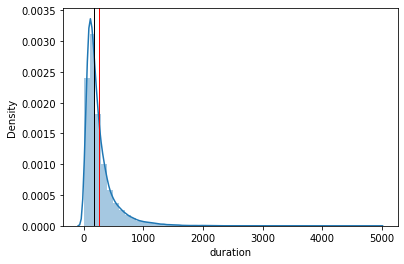

In [ ]:
sns.distplot(duration)
plt.axvline(duration.mean(), linewidth=1 , color = 'red')
plt.axvline(duration.median(), linewidth=1 , color = 'black')
plt.show()

There is only four 0 values in the duration column, which means that the data is collected only from the people who interacted with the company regarding the campain. Despite the fact that text file explaining the data suggested that 0 values may occur. As we have data of those who contacted we may have participation bias in the data. Given that we obtain duration after we know the result of interaction, so it has no predictory power and I will drop that column moving forward. Nevertheless the data on average duration may help to predict the busyness of the call center of the company.

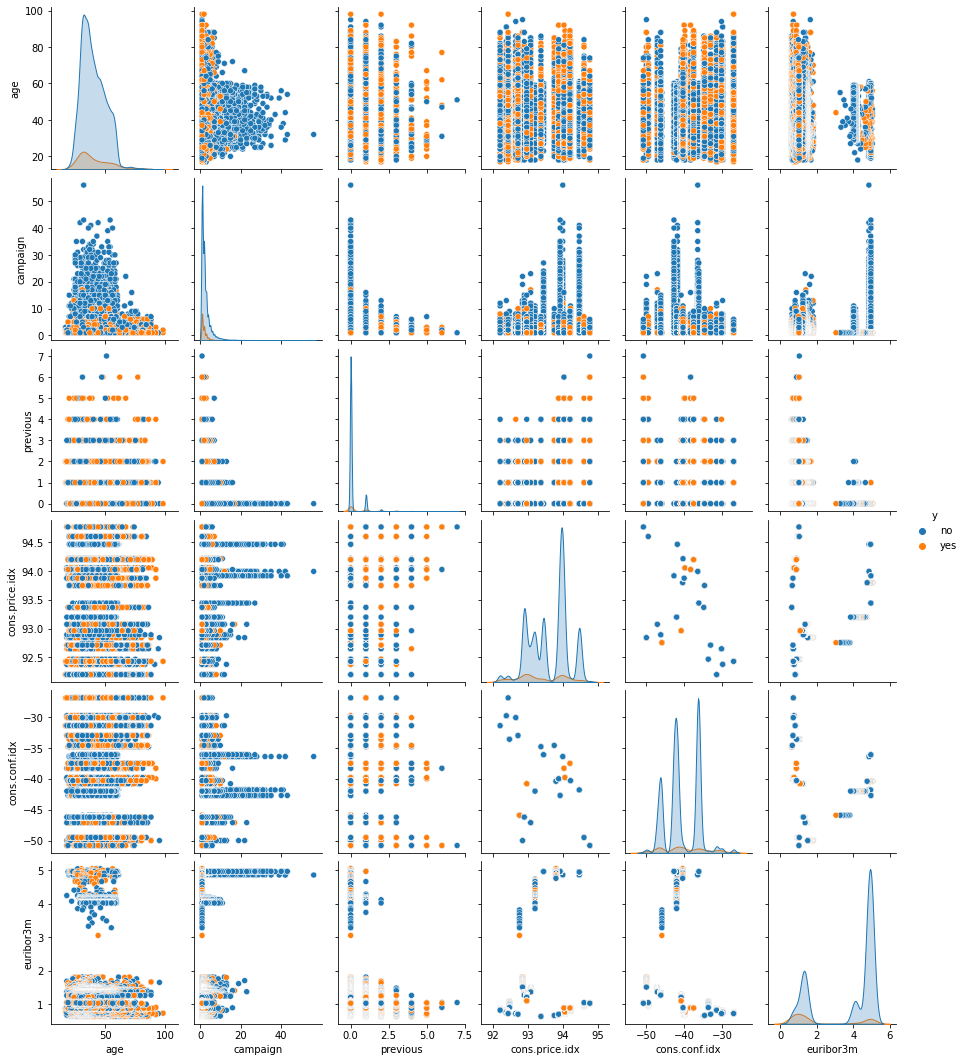

In [ ]:
sns.pairplot(
    data=data[['age', 'campaign', 'previous',
              'cons.price.idx', 'cons.conf.idx',
              'euribor3m', 'y']],
    aspect=.85,
    hue="y")
plt.show()

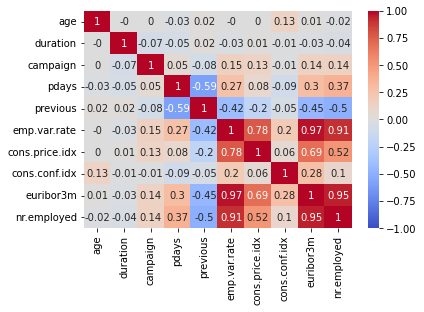

In [ ]:
corr_matrix = data.corr().round(decimals=2)
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, annot=True)
plt.show()

We can observe that the variables "emp.var.rate", "euribor3m" and "nr.employed" are clearly correlated with each other. I think we can drop the columns "emp.var.rate" and "nr.employed" as the "euribor3m" has the highest correlation with the other 2. Thus we leave only "euribor3m" variable.

Columns to drop in my oppinion. Justifies in the EDA part.

In [ ]:
data = data.drop(["pdays"], axis=1)
continious_cols.remove("pdays")
data = data.drop(["duration"], axis=1)
continious_cols.remove("duration")
data = data.drop(["emp.var.rate"], axis=1)
continious_cols.remove("emp.var.rate")
data = data.drop(["nr.employed"], axis=1)
continious_cols.remove("nr.employed")

Part2: DP

Start from checking the frequency of the data.

In [ ]:
(data.nunique() / len(data)).sort_values(ascending = False)

euribor3m         0.007672
age               0.001894
campaign          0.001020
cons.conf.idx     0.000631
cons.price.idx    0.000631
job               0.000267
month             0.000243
previous          0.000194
education         0.000170
day_of_week       0.000121
poutcome          0.000073
marital           0.000073
contact           0.000049
loan              0.000049
housing           0.000049
default           0.000049
y                 0.000049
dtype: float64

Have a look at variances of each variable.

In [ ]:
data.var().sort_values()

previous            0.244927
cons.price.idx      0.335056
euribor3m           3.008308
campaign            7.672975
cons.conf.idx      21.420215
age               108.602451
dtype: float64

We check the missing values in form of "unknown". But we should also check for the missing values among numerical columns.

In [ ]:
data[continious_cols] = data[continious_cols].replace(0, np.NaN)
print(data[continious_cols].isnull().sum())

age                   0
campaign              0
previous          35563
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
dtype: int64


In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
previous,35563,0.863431
default,8597,0.208726
education,1731,0.042027
housing,990,0.024036
loan,990,0.024036
job,330,0.008012
marital,80,0.001942
age,0,0.000000
poutcome,0,0.000000
euribor3m,0,0.000000


I think there is no need to drop the column "default". May be some people chose not to disclose that info, so their choice may still be indicative, and may carry information. Thus I think we can later transfer it to a boolean with One Hot Encoding. But I will drop the column "previous" as it has too many misssing values.

In [ ]:
data = data.drop(["previous"], axis=1)
continious_cols.remove("previous")
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,nonexistent,93.994,-36.4,4.857,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,1,nonexistent,93.994,-36.4,4.857,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,nonexistent,93.994,-36.4,4.857,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,nonexistent,93.994,-36.4,4.857,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,nonexistent,93.994,-36.4,4.857,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,nonexistent,94.767,-50.8,1.028,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,nonexistent,94.767,-50.8,1.028,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,nonexistent,94.767,-50.8,1.028,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,nonexistent,94.767,-50.8,1.028,yes


Detecting and deleting outliers.

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3.5*iqr
    fence_high = q3+3.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

Current_df = data
for col in continious_cols:
  Current_df = remove_outlier(Current_df, col)
total = Current_df.isnull().sum().sort_values(ascending=False)
percent = (Current_df.isnull().sum() / Current_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data, Current_df.shape)

                Total   Percent
default          8317  0.207438
education        1678  0.041852
housing           962  0.023994
loan              962  0.023994
job               319  0.007956
marital            75  0.001871
age                 0  0.000000
contact             0  0.000000
month               0  0.000000
day_of_week         0  0.000000
campaign            0  0.000000
poutcome            0  0.000000
cons.price.idx      0  0.000000
cons.conf.idx       0  0.000000
euribor3m           0  0.000000
y                   0  0.000000 (40094, 16)


In [ ]:
data = Current_df

Imputing the missing values

In [ ]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=True)
#strategy='median'

imputed_mean_data = pd.DataFrame(imputer_mean.fit_transform(data[continious_cols]), columns=continious_cols)
imputed_mean_data.describe().T
#data.drop(continious_cols, axis=1)
#data = pd.concat([data, imputed_mean_data], axis=1)
# print(imputed_mean_data.isnull().sum().sort_values(ascending=False))
# print(data.isnull().sum().sort_values(ascending=False))

,count,mean,std,min,25%,50%,75%,max
age,40094.0,40.016037,10.441259,17.000,32.000,38.000,47.000,98.000
campaign,40094.0,2.230458,1.622189,1.000,1.000,2.000,3.000,9.000
cons.price.idx,40094.0,93.566506,0.579538,92.201,93.075,93.444,93.994,94.767
cons.conf.idx,40094.0,-40.505562,4.658117,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,40094.0,3.592380,1.742269,0.634,1.334,4.857,4.961,5.045


In [ ]:
print(categorical_features)
print(data.head())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  campaign     poutcome  cons.price.idx  cons.conf.idx  \
0         mon         1  nonexistent          93.994          -36.4   
1         mon         1  nonexistent          93.994          -36.4   
2         mon         1  nonexistent          93.994          -36.4   
3         mon         1  nonexistent          93.994          -36.4   
4         mon         1  nonexistent        

In [ ]:
imputer_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=True)

imputed_freq_data = pd.DataFrame(imputer_freq.fit_transform(data[categorical_features]), columns=categorical_features)
# data.drop(categorical_features, axis=1)
# data = pd.concat([data, imputed_freq_data], axis=1)
print(imputed_freq_data.isnull().sum().sort_values(ascending=False))
print(data.isnull().sum().sort_values(ascending=False))
# imputed_freq_data[data[categorical_features].isna().sum(axis=1) > 0].head()


job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
y              0
dtype: int64
default           8317
education         1678
housing            962
loan               962
job                319
marital             75
age                  0
contact              0
month                0
day_of_week          0
campaign             0
poutcome             0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
y                    0
dtype: int64


I will scale the data.

In [ ]:
standard_scaler = StandardScaler()

min_max_scaler = MinMaxScaler()
print(pd.DataFrame(min_max_scaler.fit_transform(imputed_mean_data), columns=continious_cols).head())
print(data.head())

        age  campaign  cons.price.idx  cons.conf.idx  euribor3m
0  0.481481       0.0        0.698753        0.60251   0.957379
1  0.493827       0.0        0.698753        0.60251   0.957379
2  0.246914       0.0        0.698753        0.60251   0.957379
3  0.283951       0.0        0.698753        0.60251   0.957379
4  0.481481       0.0        0.698753        0.60251   0.957379
   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  campaign     poutcome  cons.price.idx  cons.conf.idx  \
0         mon         1  nonexistent          93.994      

Use One Hot Encoding to transfer the categorical values to the booleans.


In [ ]:
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    """
    Find infrequent category levels and encode them to one value
    """

    def __init__(self, tol=0.05, n_categories=5, replace_with='Rare'):
        self.tol = tol
        self.replace_with = replace_with
        self.n_categories = n_categories

    def fit(self, X):
        self.cols = X.columns
        self.encoder_dict = {}

        for c in self.cols:
            if X[c].nunique() > self.n_categories:
                t = pd.Series(X[c].value_counts() / np.float(len(X)))
                freq_idx = t[t >= self.tol].index
                self.encoder_dict[c] = freq_idx

        return self


    def transform(self, X):
        for feature in self.cols:
            if feature in self.encoder_dict.keys():
                X[feature] = np.where(
                    X[feature].isin(self.encoder_dict[feature]),
                    X[feature],
                    self.replace_with,
                )
        return X

In [ ]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
])

cat_pipe = Pipeline([
    ('rare_label_enc', RareLabelEncoder()),
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(sparse=False)),
    ('variance_trsh', VarianceThreshold(threshold=.97 * (1 - .97)))
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())
])

pipe = ColumnTransformer(transformers=[
    ('cat', cat_pipe, nominal_cols),
    ('ord', ord_pipe, ordinal_cols),
    ('num', num_pipe, continious_cols)
])

In [ ]:
X = pipe.fit_transform(data)

In [ ]:
X.shape

(40094, 38)

Part3: DR

PCA

In [ ]:
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

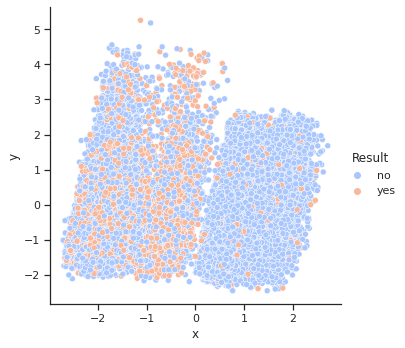

In [ ]:
plot_df = pd.DataFrame.from_records(data=new_X[:,:2],columns=["x","y"])
plot_df["Result"] = data[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="Result", palette='coolwarm')


In [ ]:
pca.explained_variance_ratio_.sum()

0.3078619108721651

In [ ]:
pca = PCA(n_components=0.95).fit(X)

len(pca.explained_variance_ratio_)

22

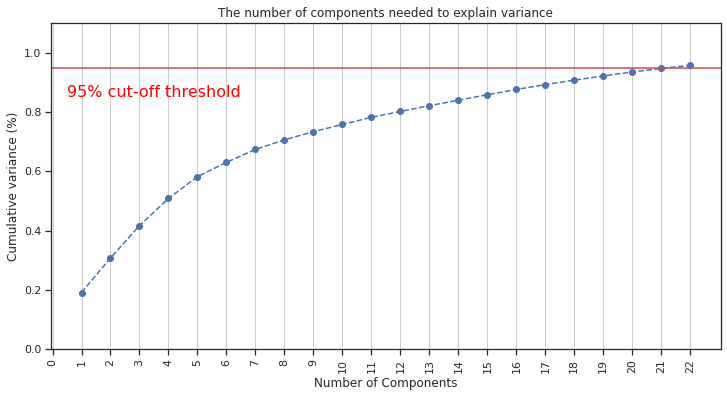

In [ ]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

We can describe the 95% of variance in the data with 38 columns with only 22 columns after PCA. We can choose the n_components=22 as optimal number of components.

SVD

In [ ]:
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_X = svd.fit_transform(X)

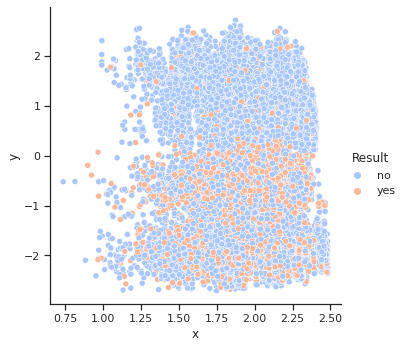

In [ ]:
plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["Result"] = data[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="Result", palette='coolwarm')

In [ ]:
svd.explained_variance_ratio_.sum()

0.19747921809028104

t-SNE

In [ ]:
tsne = TSNE()
tsne_X = tsne.fit_transform(X)

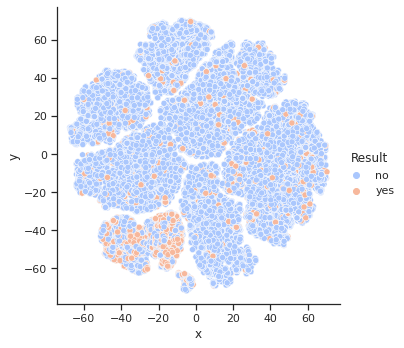

In [ ]:
plot_df = pd.DataFrame.from_records(data=tsne_X, columns=["x","y"])
plot_df["Result"] = data[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="Result", palette='coolwarm')

Citations

  [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001